In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from PIL import Image
from bs4 import BeautifulSoup as bs
import face_recognition

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import time

In [2]:
root_dir = "./data"
[os.path.join(root_dir, "Image")] + [os.path.join(root_dir, f"Image{i}") for i in range(2, 5)]

['./data/Image', './data/Image2', './data/Image3', './data/Image4']

In [3]:
len(os.listdir(os.path.join(root_dir, "Image/1"))) # "Image_large_XML/1"

1054

In [4]:
a = os.listdir(os.path.join(root_dir, "Image_large_XML/1"))[0]
lab = os.path.join(root_dir, "Image_large_XML/1", a)
with open(lab, "r") as f: data = f.read()
[(o.find("name").text, o.find("bndbox").text.strip().split("\n")) 
 for o in bs(data, "xml").find_all('object')]#.find('name')

# ET.parse(lab)

[('Normal_Eyes', ['252', '131', '437', '224']),
 ('SlightPalsy_Mouth', ['310', '174', '386', '323'])]

In [5]:
with open("./data/Image_large_XML/1/146.xml", "r") as f: cur_label = f.read()
a = [o.find("name").text.lower() for o in bs(cur_label, "xml").find_all('object')]
int(any('palsy' in q for q in a))

1

In [6]:
total = []
##### this runs forever ######

# for root, dirs, files in os.walk("./data/Image_large_XML/"):
#     for file in files:
#         if file.endswith(".xml"):
#             file_path = os.path.join(root, file)
#             with open(file_path, "r") as f: data = f.read()
#             cur_face = [o.find("name").text.lower() for o in bs(data, "xml").find_all('object')]
#             if cur_face not in total:
#                 total.append(cur_face)

total

[['slightpalsy_eyes', 'slightpalsy_mouth'],
 ['strongpalsy_eyes', 'slightpalsy_mouth'],
 ['slightpalsy_eyes', 'strongpalsy_mouth'],
 ['strongpalsy_eyes', 'strongpalsy_mouth'],
 ['normal_eyes', 'normal_mouth'],
 ['normal_eyes', 'slightpalsy_mouth'],
 ['normal_eyes', 'strongpalsy_mouth'],
 ['strongpalsy_eyes', 'normal_mouth'],
 ['slightpalsy_eyes', 'normal_mouth']]

[['slightpalsy_eyes', 'slightpalsy_mouth'],
 ['strongpalsy_eyes', 'slightpalsy_mouth'],
 ['slightpalsy_eyes', 'strongpalsy_mouth'],
 ['strongpalsy_eyes', 'strongpalsy_mouth'],
 ['normal_eyes', 'normal_mouth'],
 ['normal_eyes', 'slightpalsy_mouth'],
 ['normal_eyes', 'strongpalsy_mouth'],
 ['strongpalsy_eyes', 'normal_mouth'],
 ['slightpalsy_eyes', 'normal_mouth']]

In [7]:
# the minimum width across all images is: 360
# the minimum height across all images is: 320

min_width = 10000
min_height = 10000

# for root, dirs, files in os.walk("./data/"):
#     print(root)
#     # print(files)
#     for file in files:
#         if file.endswith(".bmp"):
#             file_path = os.path.join(root, file)
#             image = np.array(Image.open(file_path))
#             min_width = min(min_width, image.shape[1])
#             min_height = min(min_height, image.shape[0])

# print(f"the minimum width across all images is: {min_width}")
# print(f"the minimum height across all images is: {min_height}")

## Dataset

In [2]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, target_size, setOps=True, PHCNN=False, transform=None):
        super(FaceDataset, self).__init__()
        self.root_dir = root_dir
        self.target_size = target_size
        self.setOps = setOps
        self.PHCNN = PHCNN
        self.transform = transform
        self.image_dirs = [os.path.join(root_dir, "Image")] + [os.path.join(root_dir, f"Image{i}") for i in range(2, 5)]
        self.label_dir = os.path.join(root_dir, "Image_large_XML")
        self.img_links = {}
        self.mapping = {
            "normal_eyes": 0,
            "normal_mouth" : 0,
            "slightpalsy_eyes": 1,
            "strongpalsy_eyes": 2,
            "slightpalsy_mouth": 1,
            "strongpalsy_mouth": 2
        }

        if PHCNN:
            self.link_times = self.__combineFile__()
            self.segmentation_X, self.segmentation_y = self.__featureSegmentation__()
            # print(f"there are {len(self.link_times)} faces in the data")
            print(f"length of facial segmentation in total: {sum([len(f[0]) for f in self.segmentation_X])}")
        else: 
            self.X, self.y = self.__combineFile__()
            print(f"length of X: {len(self.X)}")
            print(f"length of y: {len(self.y)}")

    def __len__(self):
        if self.PHCNN: return len(self.segmentation_X)
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.PHCNN: 
            face_X, eye_X, mouth_X = self.segmentation_X[idx]

            # resize and stack
            temp = [torch.tensor(cv2.resize(face, dsize=(128, 128), interpolation=cv2.INTER_LINEAR)) for face in face_X]
            if (len(temp)==0): 
                print(f"cur idx is {idx}")
                print(f"total length of data: {len(self.segmentation_X)}")
                print(eye_X)
            face_X = torch.stack(temp)
            eye_X = torch.stack([torch.tensor(cv2.resize(eye, dsize=(120, 40), interpolation=cv2.INTER_LINEAR)) for eye in eye_X])
            mouth_X = torch.stack([torch.tensor(cv2.resize(mouth, dsize=(120, 40), interpolation=cv2.INTER_LINEAR)) for mouth in mouth_X])
            # print(self.segmentation_y[idx])
            y = torch.tensor(self.segmentation_y[idx])
            # y = torch.stack([torch.tensor(sub_y) for sub_y in self.segmentation_y[idx]])

            # reshape
            face_X = face_X.permute(3, 0, 1, 2).contiguous()
            eye_X = eye_X.permute(3, 0, 1, 2).contiguous()
            mouth_X = mouth_X.permute(3, 0, 1, 2).contiguous()
            
            return face_X, eye_X, mouth_X, y
        
        if self.transform: 
            X = self.transform(self.X[idx])
            y = torch.tensor(self.y[idx])
        else: 
            X = self.X[idx]
            y = torch.tensor(self.y[idx])
            
        return X, y

    def __combineFile__(self):
        image_matrices = []
        labels = []
        image_times = []
        subdir_cnter = 1
        label_exist = os.listdir(self.label_dir)
        # print(label_exist)

        for image_dir in self.image_dirs:
            cur = 0
            while cur < 8:
                subdir_name = str(subdir_cnter)
                # print("iter: ", cur)
                # print("sub-name: ", subdir_name)
                if subdir_name in label_exist:
                    img_pth = os.path.join(image_dir, subdir_name)
                    # print(f"img_pth is {img_pth}")
                    image_files = sorted(os.listdir(img_pth), key=lambda file: int(file.split(".")[0]))
                    lab_pth = os.path.join(self.label_dir, subdir_name)
                    label_files = sorted(os.listdir(lab_pth), key=lambda file: int(file.split(".")[0]))
                    if self.setOps: # set operations
                        img_prefix = set([f.split(".")[0] for f in image_files])
                        xml_prefix = set([f.split(".")[0] for f in label_files])
                        matching_prefix = img_prefix.intersection(xml_prefix)
                        print(f"set intersection {subdir_cnter}: {len(matching_prefix)}")
                        matching_pair = [(os.path.join(image_dir,subdir_name,prefix+".bmp"), 
                                        os.path.join(self.label_dir,subdir_name,prefix+".xml")) 
                                        for prefix in matching_prefix]

                        for img, lbl in matching_pair:
                            # image process
                            # print(lbl)
                            image = Image.open(img)

                            # label process
                            with open(lbl, "r") as f: cur_label = f.read()
                            label = [o.find("name").text.lower() for o in bs(cur_label, "xml").find_all('object')]
                            if len(label) != 2: continue
                            label_processed = [self.mapping[l] for l in label]
                            # eye_label, mouth_label = [0, 0, 0], [0, 0, 0]
                            # eye_label[label_processed[0]] = 1
                            # mouth_label[label_processed[1]] = 1

                            # store link for later usage
                            image_matrices.append(image)
                            labels.append(label_processed)
                            # labels.append([eye_label, mouth_label])
                            self.img_links[img] = label_processed #[eye_label, mouth_label]
                    else: # loop operation
                        img_cnter = 0
                        file_cnter = 0

                        while img_cnter < len(image_files):
                            if file_cnter>=len(label_files): break
                            bmp_file = image_files[img_cnter]
                            img_match = int(bmp_file.split(".")[0])
                            label_match = int(label_files[file_cnter].split(".")[0])
        
                            # print(to_match, label_files[file_cnter])
                            if img_match==label_match:
                                # image process
                                image = Image.open(img)

                                # label process
                                with open(lbl, "r") as f: cur_label = f.read()
                                label = [o.find("name").text.lower() for o in bs(cur_label, "xml").find_all('object')]
                                if len(label) != 2: continue
                                label_processed = [self.mapping[l] for l in label]
                                eye_label, mouth_label = [0, 0, 0], [0, 0, 0]
                                eye_label[label_processed[0]] = 1
                                mouth_label[label_processed[1]] = 1

                                image_matrices.append(image)
                                labels.append([eye_label, mouth_label])
                                self.img_links[img] = [eye_label, mouth_label]

                                img_cnter += 1
                                file_cnter += 1
                            elif img_match>label_match: file_cnter += 1
                            else: img_cnter += 1
                        print(f"for loop {subdir_cnter}: done")

                    # clear previous list and restart
                    if self.PHCNN:
                        if len(self.img_links): image_times.append(self.img_links)
                        self.img_links = {}

                subdir_cnter += 1
                cur += 1
        
        if self.PHCNN: return image_times
        else: return image_matrices, labels
    
    def __featureSegmentation__(
            self, scaleFactor=1.29, minNeighbors=8, 
            shrink_factor=2, padding=10):
        segmentation_X, segmentation_y = [], []
        face_classifier = cv2.CascadeClassifier(
            cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        )
        total = sum([len(faces) for faces in self.link_times])
        print(f"Segmentation begins, there are {total} images")
        for faces in self.link_times:
            # sort faces by their key value
            for k in faces:
                cur_k = k
                break
            # print(f"there are {len(faces)} images", end=", ")
            # print(cur_k)
            print(f"Image {cur_k.split('/')[3]} folder begin to segment...")
            start = time.time()
            face_sequence = sorted(faces.keys(), 
                                   key=lambda x: int(x.split("/")[-1].split(".")[0]))
            cur_face_X, cur_eye_X, cur_mouth_X = [], [], []
            cur_face_y = []
            for img_link in face_sequence:
                img = cv2.imread(img_link)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # resize the imaage so that the run time is faster
                height = int(img.shape[0] / shrink_factor)
                height_percent = (height / img.shape[0])
                width = int((img.shape[1] * height_percent))
                img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

                # segment face
                gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                face = face_classifier.detectMultiScale(
                    gray_img, scaleFactor=scaleFactor, minNeighbors=minNeighbors
                )

                if len(face) != 1: 
                    print(f"\t    skipping {img_link} because != 1 face recognized. Face detected: {len(face)}")
                    continue
                x, y, w, h = face[0]
                face_X = img[y:y+h, x:x+w]

                
                left_eyes, right_eyes, top_eyes, bottom_eyes = [], [], [], []
                left_mouth, right_mouth, top_mouth, bottom_mouth = [], [], [], []

                # segment eyes and mouth
                facial_landmarks = face_recognition.face_landmarks(face_X)
                if len(facial_landmarks) != 1: 
                    print(f"\t    skipping {img_link} because != 1 facial feature detected. Feature detected: {len(facial_landmarks)}")
                    # plt.imshow(face_X)
                    continue

                hpadding = padding // 3 # ensure 40x120 dimension percentage
                for landmarks in facial_landmarks:
                    left_eye = landmarks["left_eye"]
                    right_eye = landmarks["right_eye"]
                    left_eb = landmarks["left_eyebrow"]
                    right_eb = landmarks["left_eyebrow"]
                    top_lip = landmarks["top_lip"]
                    btm_lip = landmarks["bottom_lip"]

                    # eyes
                    for (x, y) in left_eb:
                        left_eyes.append(x-padding)
                        right_eyes.append(x+padding)
                        bottom_eyes.append(y+hpadding)
                        top_eyes.append(y-hpadding)
                    for (x, y) in right_eb:
                        left_eyes.append(x-padding)
                        right_eyes.append(x+padding)
                        bottom_eyes.append(y+hpadding)
                        top_eyes.append(y-hpadding)
                    for (x, y) in left_eye:
                        left_eyes.append(x-padding)
                        right_eyes.append(x+padding)
                        bottom_eyes.append(y+hpadding)
                        top_eyes.append(y-hpadding)
                        # cv2.rectangle(rgb_image, (x-5, y-5), (x+5, y+5), (0, 255, 0), 2)
                    for (x, y) in right_eye:
                        left_eyes.append(x-padding)
                        right_eyes.append(x+padding)
                        bottom_eyes.append(y+hpadding)
                        top_eyes.append(y-hpadding)

                    up_bound = face_X.shape[0]
                    left = max(0, min(left_eyes))
                    right = min(up_bound, max(right_eyes))
                    bottom = min(up_bound, max(bottom_eyes))
                    top = max(0, min(top_eyes))
                    eye_X = face_X[top:bottom, left:right]

                    # mouth
                    for (x, y) in top_lip:
                        left_mouth.append(x-padding)
                        right_mouth.append(x+padding)
                        bottom_mouth.append(y+hpadding)
                        top_mouth.append(y-hpadding)
                        # cv2.rectangle(rgb_image, (x-5, y-5), (x+5, y+5), (0, 0, 255), 2)
                    for (x, y) in btm_lip:
                        left_mouth.append(x-padding)
                        right_mouth.append(x+padding)
                        bottom_mouth.append(y+hpadding)
                        top_mouth.append(y-hpadding)

                    left = max(0, min(left_mouth))
                    right = min(up_bound, max(right_mouth))
                    bottom = min(up_bound, max(bottom_mouth))
                    top = max(0, min(top_mouth))
                    mouth_X = face_X[top:bottom, left:right]

                cur_face_X.append(face_X)
                cur_eye_X.append(eye_X)
                cur_mouth_X.append(mouth_X)
                cur_face_y.append(faces[img_link])
                # if len(cur_face_X)==0:
                #     print(f"\tbatch {batch_seq} has some problem")

                if len(cur_face_X) == 4:
                    segmentation_X.append([cur_face_X, cur_eye_X, cur_mouth_X])
                    segmentation_y.append(cur_face_y)
                    cur_face_X, cur_eye_X, cur_mouth_X = [], [], []
                    cur_face_y = []

            print(f"\tFinish Image {cur_k.split('/')[3]} in {time.time()-start} sec...")
            # print(segmentation_y)
            # if int(cur_k.split('/')[3]) > 1:
            #     break

            # segmentation_X.append([cur_face_X, cur_eye_X, cur_mouth_X])
            # segmentation_y.append(cur_face_y)
        
        return segmentation_X, segmentation_y

In [3]:
# 16972 originally
# 16963 after shrinking
target_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
])
dataset = FaceDataset("./data", target_size, setOps=True, PHCNN=True, transform=transform)

set intersection 1: 1054
set intersection 2: 473
set intersection 3: 193
set intersection 4: 283
set intersection 5: 397
set intersection 8: 2066
set intersection 9: 1594
set intersection 10: 156
set intersection 11: 735
set intersection 12: 1
set intersection 13: 1050
set intersection 14: 687
set intersection 15: 420
set intersection 16: 238
set intersection 17: 309
set intersection 22: 245
set intersection 23: 280
set intersection 26: 277
set intersection 27: 1507
set intersection 28: 2296
set intersection 29: 1376
set intersection 30: 1208
set intersection 31: 127
Segmentation begins, there are 16963 images
Image 1 folder begin to segment...
	Finish Image 1 in 20.821060180664062 sec...
Image 2 folder begin to segment...
	    skipping ./data/Image/2/736.bmp because != 1 facial feature detected. Feature detected: 0
	    skipping ./data/Image/2/746.bmp because != 1 facial feature detected. Feature detected: 0
	    skipping ./data/Image/2/856.bmp because != 1 facial feature detected. Fe

In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
num_iter = 0
for face_X, eye_X, mouth_X, y in train_dataset:
    if num_iter > 0: break
    print(face_X.size())
    print(y)
    num_iter += 1

torch.Size([3, 4, 128, 128])
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])


In [7]:
train_loader = DataLoader(train_dataset, batch_size=8, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)
# a = DataLoader(dataset)
len(train_loader), len(test_loader)

(407, 101)

In [8]:
num_iter = 0
for face_X, eye_X, mouth_X, y in train_loader:
    if num_iter > 0: break
    print(face_X.shape)
    print(y.shape)
    num_iter += 1

torch.Size([8, 3, 4, 128, 128])
torch.Size([8, 4, 2])


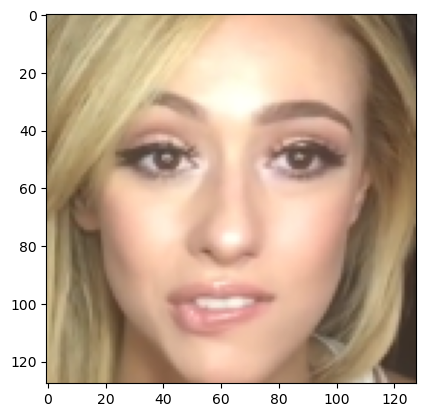

In [13]:
images = []
for i in range(face_X.size(2)):
    plt.imshow(face_X[0, :, i, :, :].permute(1,2,0))
    # scaled = face_X[0, :, i, :, :].numpy().transpose(1,2,0) * 255
    # image = scaled.astype(np.uint8)
    # images.append(image)

In [14]:
# print(y[0][3])
# plt.imshow(images[3])
# plt.axis("off")
# plt.show()

## Model

In [37]:
class ModifiedVGG(nn.Module):
    def __init__(self, hidden_lstm, num_layer_lstm, out_dim):
        super(ModifiedVGG, self).__init__()
        self.idx2eye = {0: "normal_eyes", 1:"slightpalsy_eyes", 2:"strongpalsy_eyes"}
        self.idx2mouth = {0: "normal_mouth", 1:"slightpalsy_mouth", 2:"strongpalsy_mouth"}
        self.palsy2score = {
            "normal_eyesnormal_eyes":0,
            "normal_eyesslightpalsy_eyes":1,
            "normal_eyesstrongpalsy_eyes":2,
            "slightpalsy_eyesnormal_eyes":3,
            "slightpalsy_eyesslightpalsy_eyes":4,
            "slightpalsy_eyesstrongpalsy_eyes":5,
            "strongpalsy_eyesnormal_eyes":6,
            "strongpalsy_eyesslightpalsy_eyes":7,
            "strongpalsy_eyesstrongpalsy_eyes":8
        }
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.fc = nn.Linear(4096, 9)
        self.activation = nn.Softmax(dim=1)

        self.vgg = models.vgg16(pretrained=True)
        num_features = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Linear(num_features, 1024)
        self.lstm = nn.LSTM(1024, hidden_lstm, num_layer_lstm, batch_first=True)
        self.severity_grading = nn.Linear(hidden_lstm, out_dim)
        self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        embed_seq = []
        hidden = None
        for i in range(x.size(2)):
            cur_embed = self.vgg(x[:, :, i, :, :])
            embed_seq.append(cur_embed)
        embed_seq = torch.stack(embed_seq, dim=0)
        embed_seq = embed_seq.transpose(0, 1)

        out, hidden = self.lstm(embed_seq, hidden)
        out = self.severity_grading(out[:, -1, :])#.flatten()
        out = self.activation(out)
        # x = self.features(x)
        # x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.classifier(x)
        # x = self.fc(x)
        # out = self.activation(x)
        return out
    
    def transform_y(self, y):
        out = []
        for batch_y in y:
            combinations, counts = torch.unique(batch_y, dim=0, return_counts=True)
            video_label = combinations[torch.argmax(counts)].tolist()

            new_label = [0] * 9
            video_label[0] = self.idx2eye[video_label[0]]
            video_label[1] = self.idx2eye[video_label[1]]
            new_label[self.palsy2score["".join(video_label)]] = 1
            out.append(new_label)

        return torch.tensor(out)
    
    def acc(self, pred, label):
        pred_idx = torch.argmax(pred, dim=1)
        label_idx = torch.argmax(label, dim=1)
        return sum(pred_idx==label_idx).item()/pred_idx.size()[0]

# models.vgg16(weights=None)

In [28]:
net = ModifiedVGG(64, 2, 9)
# net = models.vgg16(pretrained=True)
pred = net(face_X.float())
# net.features
pred.size()

/home/haptic/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/haptic/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 9])

## Model Training & Validating

In [33]:
# weight_dict = {}
# for X, y in train_loader:
#     # print(1)
#     for idx in torch.argmax(y, dim=1):
#         idx = idx.item()
#         if idx not in weight_dict:
#             weight_dict[idx] = 1
#         else: weight_dict[idx] += 1

weight_dict = {}
for face_X, eye_X, mouth_X, y in train_loader:
    # print(1)
    cur_vals = torch.argmax(net.transform_y(y), dim=1)
    for idx in cur_vals:
        idx = idx.item()
        if idx not in weight_dict:
            weight_dict[idx] = 1
        else: weight_dict[idx] += 1

print(weight_dict)
most_occ = max([v for k, v in weight_dict.items()])

weights = [0] * 9
for k in weight_dict:
    weights[k] = most_occ/weight_dict[k]

weights = torch.FloatTensor(weights)
weights

{3: 45, 4: 2116, 5: 82, 1: 691, 0: 272, 8: 5, 6: 16, 7: 26, 2: 3}


tensor([  7.7794,   3.0622, 705.3333,  47.0222,   1.0000,  25.8049, 132.2500,
         81.3846, 423.2000])

In [34]:
def train_model(model, train_data, test_data, weights, num_epochs, lr, device):
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(weight=weights)
    out_train_acc, out_val_acc = [], []

    for epoch in range(num_epochs):
        train_losses, val_losses = 0.0, 0.0
        train_accs, val_accs = 0.0, 0.0
        model.train()
        print(f"Epoch {epoch+1} begins:", end="")
        cur_batch = 1
        batch_size = len(train_data) // 5

        for face_X, eye_X, mouth_X, y in train_data:
            optimizer.zero_grad() # zero grad

            face_X = face_X.float().to(device)
            label = model.transform_y(y).float().to(device)
            pred = model(face_X)
            # print(f"pred type: {pred.device.type}")
            # print(f"label type: {label.device.type}")
            # print(f"\tpred: {pred}\n\t\tground truth: {label}")
            loss = criterion(pred, label) # compute loss
            accuracy = model.acc(pred, label)

            loss.backward() # backpropagate
            optimizer.step() # optimization
            train_losses += loss.item()
            train_accs += accuracy
            # print("-", end="")

            cur_batch += 1

            if (cur_batch % batch_size == 0):
                model.eval()
                val_losses = 0.0
                val_accs = 0.0
                with torch.no_grad():
                    for face_X, eye_X, mouth_X, y in test_data:
                        face_X = face_X.float().to(device)
                        pred = model(face_X)
                        label = model.transform_y(y).float().to(device)
                        loss = criterion(pred, label)
                        accuracy = model.acc(pred, label)
                        val_losses += loss.item()
                        val_accs += accuracy

                    print(f"\n\tBatch {cur_batch}\tTraining Loss: {train_losses/batch_size:.3f}\tValidation Loss: {val_losses/len(test_data):.3f}")
                    print(f"\t\t\tTraining Acc: {train_accs/batch_size*100:.3f}%\tValidation Acc: {val_accs/len(test_data)*100:.3f}%", end="")
                    out_train_acc.append(train_accs/batch_size)
                    out_val_acc.append(val_accs/len(test_data))
                
                train_losses = 0
                train_accs = 0
                model.train()
        print()
    
    return out_train_acc, out_val_acc

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda')

In [38]:
loss_weight = weights.to(device)
net = ModifiedVGG(512, 2, 9)
train_acc, val_acc = train_model(net, train_loader, test_loader, loss_weight, 30, 0.0005, device)

/home/haptic/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/haptic/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 begins:
	Batch 81	Training Loss: 13.262	Validation Loss: 16.364
			Training Acc: 5.864%	Validation Acc: 7.302%
	Batch 162	Training Loss: 9.416	Validation Loss: 16.358
			Training Acc: 9.105%	Validation Acc: 4.455%
	Batch 243	Training Loss: 11.355	Validation Loss: 16.378
			Training Acc: 13.580%	Validation Acc: 36.510%
	Batch 324	Training Loss: 16.260	Validation Loss: 16.351
			Training Acc: 3.086%	Validation Acc: 2.228%
	Batch 405	Training Loss: 13.483	Validation Loss: 16.367
			Training Acc: 2.006%	Validation Acc: 1.114%
Epoch 2 begins:
	Batch 81	Training Loss: 13.271	Validation Loss: 16.357
			Training Acc: 1.852%	Validation Acc: 1.609%
	Batch 162	Training Loss: 9.411	Validation Loss: 16.349
			Training Acc: 5.093%	Validation Acc: 13.985%
	Batch 243	Training Loss: 11.343	Validation Loss: 16.357
			Training Acc: 12.346%	Validation Acc: 26.361%
	Batch 324	Training Loss: 16.271	Validation Loss: 16.362
			Training Acc: 4.938%	Validation Acc: 14.109%
	Batch 405	Training Loss: 13.4

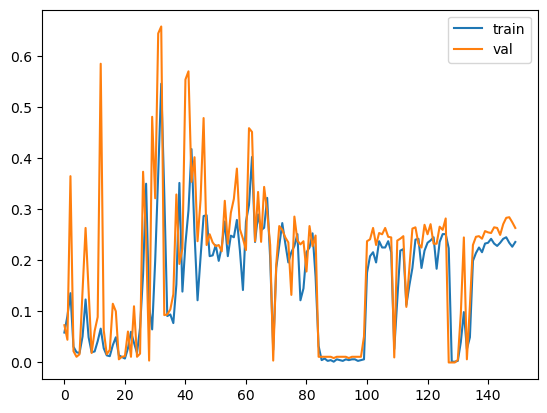

In [39]:
plt.plot(train_acc, label="train")
plt.plot(val_acc, label="val")
plt.legend()
plt.show()